### MD Muhaimin Rahman
contact: sezan92@gmail.com


# Introduction

In this notebook, I am describing the implementation of Control Systems namely [PID](#pid_sec),[Fuzzy Logic](#fuzzy_sec) and [LQR](#lqr_sec) on our robot. The $pidcontrol.py$ file has been used for our project. I haven't written this library. I have downloaded from this github project.[1](#pid)

#### Importing Libraris

In [ ]:
import sys,time
import pidcontrol as pid
import rospy
from geometry_msgs.msg import Twist
from sensor_msgs.msg import Imu
from std_msgs.msg import Float32

Topic names

In [ ]:
Yaw_Topic = "/yaw"
cmd_vel = "/cmd_vel"
Imu_topic = "/imu"
Kp_topic = "/Kp"
Ki_topic ="/Ki"
Kd_topic = "/Kd"


/yaw topic is used to publish the response value of the yaw angle of the robot
/cmd_vel topic is used to move the robot. 
/imu topic gets the imu sensor data
/Kp , /Ki and /Kd topics are used to tune the PID gains for the robot. The pid gains can be tuned using rqt_ez_publisher gui which is automatically launched with the whole project

<a id = "pid_sec"></a>
### PID

The class below , "SelfBalance" does the main job. In this class, we see , one subscriber for cmd_vel topic which moves the robot. Also four subscriber functions. One subscriber function for accessing Imu values. The other subscriber functions to tune the PID gains . For PID controller function I have used a python code named $pidcontrol.py$ from the project at [1](#pid)

In [ ]:
class SelfBalance:
    def __init__(self):
        self.pub = rospy.Publisher(cmd_vel,Twist,queue_size =1)
        self.subscriber = rospy.Subscriber(Imu_topic,Imu,self.callback)
        self.subscriber2 = rospy.Subscriber(Kp_topic,Float32,self.callback_Kp)
        self.subscriber3 = rospy.Subscriber(Ki_topic,Float32,self.callback_Ki)
        self.subscriber4 = rospy.Subscriber(Kd_topic,Float32,self.callback_Kd)
        self.pub1 = rospy.Publisher(Yaw_Topic,Float32,queue_size =1)
        self.xvelMin=-.01
        self.xvelMax =0
        self.yMin = -0.01
        self.yMax = -0.001
        self.yPrev =0
        self.delY = 0
        self.Kp = 25
        self.Ki = 0.8
        self.Kd = 0.1
        self.pubx = pid.PID_Controller(self.Kp,self.Ki,self.Kd)
    def callback(self,data):
        setPoint = 0
        y = data.orientation.y
        self.delY = y-self.yPrev
        if self.delY>self.yMax:
            self.yMax = self.delY
        elif self.delY<self.yMin:
            self.yMin = self.delY
        vel = Twist()
        xvel = -self.pubx.getCorrection(setPoint,y)
        if xvel>self.xvelMax:
            self.xvelMax=xvel
        elif xvel<self.xvelMin:
            self.xvelMin = xvel
        if xvel >26:
            xvel =26
        elif xvel<-26:
            xvel =-26
        vel.linear.x = xvel
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x =0
        vel.angular.y = 0
        vel.angular.z = 0

        self.pub.publish(vel)
        self.yPrev = y
        self.pub1.publish(y)
        #print "Max vel " + str(self.xvelMax) + " & Min vel " + str(self.xvelMin) + " Max delY " + str(self.yMax*180/3.1416) +" & Min delY" + str(self.yMin*180/3.1416)
    def callback_Kp(self,data):
        self.Kp = data.data
        self.pubx = pid.PID_Controller(self.Kp,self.Ki,self.Kd)
    def callback_Ki(self,data):
        self.Ki = data.data
        self.pubx = pid.PID_Controller(self.Kp,self.Ki,self.Kd)
    
    def callback_Kd(self,data):
        self.Kd = data.data
        self.pubx = pid.PID_Controller(self.Kp,self.Ki,self.Kd)
        

Main Function

In [ ]:
def main(args):
    '''Initializes and cleanup ros node'''
    rospy.init_node('SelfBalance', anonymous=True)
    ic = SelfBalance()
    
    try:
        rospy.spin()
    except KeyboardInterrupt:
        print "Shutting down ROS "
    

if __name__ == '__main__':
    main(sys.argv)


### Video

[Youtube Link](https://youtu.be/kssD8unnWls)

<a id ="fuzzy_sec"></a>
## Fuzzy Logic Controller

There are many things in common between the PID code and Fuzzy logic code for the robot, as expected. For fuzzy rule definition , I have written a seperate file namee $SelfBalancingFuzzyP.py$. Fuzzy logic can be of many types. For simplicity, I have shown Fuzzy P controller. I have used scikit-fuzzy library for our purpose.[[2](#fuzzy)] The codes are as following

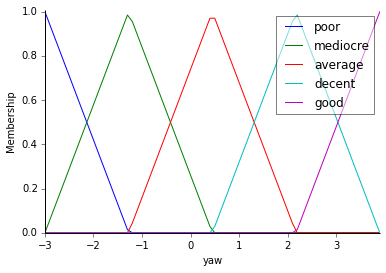

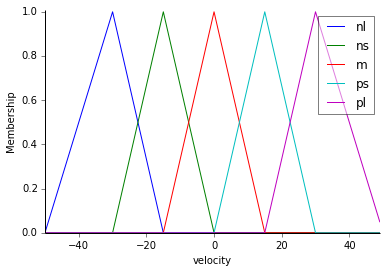

In [5]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  3 15:22:37 2017

@author: sezan92
"""

# In[1]
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
yaw = ctrl.Antecedent(np.arange(-3,4,0.1), 'yaw')
#yaw_=ctrl.Antecedent(np.arange(-1,1,0.4),'diff_yaw')
velocity = ctrl.Consequent(np.arange(-50, 50, 1), 'velocity')

# Auto-membership function population is possible with .automf(3, 5, or 7)
yaw.automf(5)
#yaw_.automf(5)
# Custom membership functions can be built interactively with a familiar,
# Pythonic API
velocity['nl'] = fuzz.trimf(velocity.universe, [-50,-30,-15])
velocity['ns'] = fuzz.trimf(velocity.universe, [-30, -15, 0])
velocity['m'] = fuzz.trimf(velocity.universe, [-15,0,15])
velocity['ps'] =fuzz.trimf(velocity.universe,[0,15,30])
velocity['pl'] = fuzz.trimf(velocity.universe,[15,30,50])
yaw.view()
#yaw_.view()
velocity.view()

# In[2]
#rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule1 = ctrl.Rule(yaw['poor'],velocity['nl'])
rule2 = ctrl.Rule(yaw['mediocre'] ,velocity['ns'])
rule3 = ctrl.Rule(yaw['average'],velocity['m'])
rule4 = ctrl.Rule(yaw['decent'],velocity['ps'])
rule5 = ctrl.Rule(yaw['good'],velocity['pl'])

#rule1.view()

# In[3]
velocity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4,rule5])
xvel1 = ctrl.ControlSystemSimulation(velocity_ctrl)

The code for Fuzzy Logic implementation on the control system of the robot

In [ ]:
class SelfBalanceFuzzy:
    def __init__(self):
        self.pub = rospy.Publisher(cmd_vel,Twist,queue_size =1)
        self.subscriber = rospy.Subscriber(Imu_topic,Imu,self.callback)
        self.pub1 = rospy.Publisher(Yaw_Topic,Float32,queue_size =1)
        self.xvelMin=-.01
        self.xvelMax =0
        self.yMin = -0.01
        self.yMax = 0
        self.y_ = 0
    def callback(self,data):
        global counter
        stamp = data.header.stamp
        time = stamp.secs+stamp.nsecs*1e-9
        setPoint = 0
        y = data.orientation.y*180/3.1416
        if y>self.yMax:
            self.yMax = y
        elif y<self.yMin:
            self.yMin =y
        vel = Twist()
        velocity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4,rule5])
        xvel1 = ctrl.ControlSystemSimulation(velocity_ctrl)

        xvel1.input['yaw']=(y-setPoint)
        
        xvel1.compute()
        xvel = xvel1.output['velocity']
        
        
        if xvel>self.xvelMax:
            self.xvelMax=xvel
        elif xvel<self.xvelMin:
            self.xvelMin = xvel
        vel.linear.x = xvel
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x =0
        vel.angular.y = 0
        vel.angular.z = 0
        self.pub.publish(vel)
        #print "Max vel " + str(self.xvelMax) + " & Min vel " + str(self.xvelMin) + " Max y " + str(self.yMax*180/3.1416) +" & Min y" + str(self.yMin*180/3.1416)
        print "Velocity "+ str(xvel)+ " & yaw " + str(y)
        self.y_ = y
        self.pub1.publish(data.orientation.y)
'''        if counter%10==0:
            plt.plot(y,time)
            plt.axis('equal')
            plt.draw()
            plt.pause(0.0000001)
        counter = counter+1'''

def main(args):
    '''Initializes and cleanup ros node'''
    rospy.init_node('SelfBalance', anonymous=True)
    ic = SelfBalanceFuzzy()
    
    try:
        rospy.spin()
    except KeyboardInterrupt:
        print "Shutting down ROS "
    

### Video

[Youtube Link](https://youtu.be/FoG59xl2c9I)


# LQR Controller

Here, I am working on LQR controller. I have used control library [[3](#PythonControl)] of python to work on lqr. For the lqr controllers, the state-space equations of the system are required. For the Inverted pendulum , the equation will be the following

![system](LQR.png)

The above equation is derived from [[4](#SystemEquation)] .Here, $m$ mass of the pendulum, $I$ is mass moment of Inertia , $M$ mass of Cart, $g$ gravitational acceleration, $\phi$ yaw angle, $u$ is force and $x$ is the movement of the cart. we can simplify by writing , $\dot{x} = Ax+Bu $, where A and B in our robot will be the following

In [6]:
A = np.array([[0,1],[47.77,0]])
B = np.array([[  0.  ],
       [ 10.52]])

From [[4](#SystemEquation)] , we get the cost function \begin{equation}
J = \int (x^TQx +u^TRu)dt
\end{equation}


Here, we need to tune Q matrix and R such that the value of $J$ is minimum.

Our topics for LQR

In [7]:
cmd_vel = "/cmd_vel"
Imu_topic = "/imu"
Yaw_Topic = "/yaw"
q_topic = "/Q"
r_topic ="/R"

Here, we will tune the values of Q and R using /Q and /R topic respectively.

The class for LQR

In [8]:
class SelfBalanceLQR:
    def __init__(self):
        self.pub = rospy.Publisher(cmd_vel,Twist,queue_size =1)
        self.subscriber = rospy.Subscriber(Imu_topic,Imu,self.callback)
        self.subscriber2 = rospy.Subscriber(q_topic,Float32,self.callback_q)
        self.subscriber3= rospy.Subscriber(r_topic,Float32,self.callback_r)
        self.pub1 = rospy.Publisher(Yaw_Topic,Float32,queue_size =1)
        self.xvelMin=-.01
        self.xvelMax =0
        self.yMin = -0.01
        self.yMax = 0
        self.y_ = 0
        self.Q = np.array([[ 100,   0],[  0, 1000]])
        self.R = 0.0001
        #xvel = xvel1.output['velocity']
        self.K,self.S,self.e = lqr(A,B,self.Q,self.R)
    def callback(self,data):
        self.K,self.S,self.e = lqr(A,B,self.Q,self.R)
        y = data.orientation.y*180/3.1416
        if y>self.yMax:
            self.yMax = y
        elif y<self.yMin:
            self.yMin =y
        vel = Twist()
        diff_yaw = y-self.y_
        np_x = np.array([[y],[diff_yaw]])

        xvel = self.K.dot(np_x)[0,0]
       
        if xvel>self.xvelMax:
            self.xvelMax=xvel
        elif xvel<self.xvelMin:
            self.xvelMin = xvel
        vel.linear.x = xvel
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x =0
        vel.angular.y = 0
        vel.angular.z = 0
        self.pub.publish(vel)
        #print "Max vel " + str(self.xvelMax) + " & Min vel " + str(self.xvelMin) + " Max y " + str(self.yMax*180/3.1416) +" & Min y" + str(self.yMin*180/3.1416)
        #print "Velocity "+ str(xvel)+ " & yaw " + str(y)
        self.y_ = y
        self.pub1.publish(data.orientation.y)
    def callback_q(self,data):
        q = data.data
        self.Q = np.array([[ q,   0],[  0, 10*q]])
        
        
    def callback_r(self,data):
        r = data.data
        self.R = r


## Video

[Youtube Link](https://youtu.be/QmrRNw043dY)

## Conclusion

In this project , I have tested three famous controllers on Self Balancing Robot Simulation. I am planning to work on other controllers as well, like Fuzzy PID, Adaptive Fuzzy, Neural Network, Sliding motion controller etc. I also intend to work on other control system problems as well. Control System is fun! Please contact me for any confusions or bugs. 

#### MD Muhaimin Rahman


# Reference

<a id ="pid"></a>
[1] PyQuadSim [Repository](https://github.com/simondlevy/PyQuadSim/blob/master/pidcontrol.py)
<br/>
<a id ="fuzzy"></a>
[2] Scikit-fuzzy DOI link 10.5281/zenodo.1002946
<br/>
<a id ="PythonControl"></a>
[3] Python Control Package , [link](https://python-control.readthedocs.io/en/latest/)
<br/>
<a id ="SystemEquation"></a>
[4] Control System Tutorials , [link](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling)